In [1]:
import sys
from dotenv import load_dotenv
import os

load_dotenv()

sys.path.append(os.getenv("ROOT"))

In [2]:
import polars as pl
import numpy as np
from datetime import date
from silverfund.datasets import CRSPDaily
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load dataset
df = CRSPDaily(start_date=date(2006, 1, 1), end_date=date(2024, 12, 31)).load_all().select(["permno", "ticker", "date", "shrout", "prc", "ret"])

df

permno,ticker,date,shrout,prc,ret
i64,str,date,f64,f64,f64
10001,"""EWST""",2006-01-03,2930.0,9.69,-0.001031
10001,"""EWST""",2006-01-04,2930.0,9.8,0.011352
10001,"""EWST""",2006-01-05,2930.0,9.55,-0.02551
10001,"""EWST""",2006-01-06,2930.0,9.399,-0.015812
10001,"""EWST""",2006-01-09,2930.0,8.92,-0.050963
…,…,…,…,…,…
93436,"""TSLA""",2024-11-22,3.207e6,352.56,0.03804
93436,"""TSLA""",2024-11-25,3.207e6,338.59,-0.039625
93436,"""TSLA""",2024-11-26,3.207e6,338.23001,-0.001063


In [4]:
# Form reversal signal

# Log returns
df = df.with_columns(pl.col("ret").log1p().alias("logret"))

# Rolling sum from t-23 to t-1
df = df.with_columns(pl.col("logret").rolling_sum(window_size=22, min_periods=22).shift(1).over("permno").alias("rev"))

df

permno,ticker,date,shrout,prc,ret,logret,rev
i64,str,date,f64,f64,f64,f64,f64
10001,"""EWST""",2006-01-03,2930.0,9.69,-0.001031,-0.001032,null
10001,"""EWST""",2006-01-04,2930.0,9.8,0.011352,0.011288,null
10001,"""EWST""",2006-01-05,2930.0,9.55,-0.02551,-0.025841,null
10001,"""EWST""",2006-01-06,2930.0,9.399,-0.015812,-0.015938,null
10001,"""EWST""",2006-01-09,2930.0,8.92,-0.050963,-0.052307,null
…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-11-22,3.207e6,352.56,0.03804,0.037334,0.443528
93436,"""TSLA""",2024-11-25,3.207e6,338.59,-0.039625,-0.040431,0.50088
93436,"""TSLA""",2024-11-26,3.207e6,338.23001,-0.001063,-0.001064,0.262262


In [5]:
# Filters

# Price greater than 5
df = df.with_columns(pl.col("prc").shift(1).over("permno").alias("prclag"))
df = df.filter(pl.col("prclag") > 5)

# Non-null reversal signal
df = df.drop_nulls(subset=["rev"])

df

permno,ticker,date,shrout,prc,ret,logret,rev,prclag
i64,str,date,f64,f64,f64,f64,f64,f64
10001,"""EWST""",2006-02-03,2930.0,9.51,-0.021595,-0.021832,0.00714,9.7199
10001,"""EWST""",2006-02-06,2930.0,9.6,0.009464,0.009419,-0.01366,9.51
10001,"""EWST""",2006-02-07,2930.0,9.25,-0.036458,-0.037139,-0.015528,9.6
10001,"""EWST""",2006-02-08,2931.0,9.4,0.016216,0.016086,-0.026826,9.25
10001,"""EWST""",2006-02-09,2931.0,9.6,0.021277,0.021054,0.005198,9.4
…,…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-11-22,3.207e6,352.56,0.03804,0.037334,0.443528,339.64001
93436,"""TSLA""",2024-11-25,3.207e6,338.59,-0.039625,-0.040431,0.50088,352.56
93436,"""TSLA""",2024-11-26,3.207e6,338.23001,-0.001063,-0.001064,0.262262,338.59


In [6]:
# Create portfolio bins

labels = [str(x) for x in range(10)]

df = df.with_columns(pl.col("rev").qcut(10, labels=labels).over("date").alias("bin"))

df

permno,ticker,date,shrout,prc,ret,logret,rev,prclag,bin
i64,str,date,f64,f64,f64,f64,f64,f64,cat
10001,"""EWST""",2006-02-03,2930.0,9.51,-0.021595,-0.021832,0.00714,9.7199,"""3"""
10001,"""EWST""",2006-02-06,2930.0,9.6,0.009464,0.009419,-0.01366,9.51,"""2"""
10001,"""EWST""",2006-02-07,2930.0,9.25,-0.036458,-0.037139,-0.015528,9.6,"""2"""
10001,"""EWST""",2006-02-08,2931.0,9.4,0.016216,0.016086,-0.026826,9.25,"""2"""
10001,"""EWST""",2006-02-09,2931.0,9.6,0.021277,0.021054,0.005198,9.4,"""4"""
…,…,…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-11-22,3.207e6,352.56,0.03804,0.037334,0.443528,339.64001,"""9"""
93436,"""TSLA""",2024-11-25,3.207e6,338.59,-0.039625,-0.040431,0.50088,352.56,"""9"""
93436,"""TSLA""",2024-11-26,3.207e6,338.23001,-0.001063,-0.001064,0.262262,338.59,"""9"""


In [7]:
# Create portfolio returns dataframe

# Aggregate (equal weight portfolios)
port = df.group_by(["date", "bin"]).agg(pl.col("ret").mean())

# Pivot
port = port.pivot(on="bin", index="date", values="ret")

# Reorder columns
port = port.select(["date"] + labels)

# Sort
port = port.sort(by="date")

port

date,0,1,2,3,4,5,6,7,8,9
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2006-02-03,-0.001629,-0.001505,-0.001455,-0.00189,-0.000777,-0.003019,-0.001906,-0.000761,-0.002496,-0.004197
2006-02-06,-0.0022,0.00196,0.001091,0.002135,0.000976,0.001075,0.005345,0.006245,0.00592,0.0083
2006-02-07,-0.008769,-0.006095,-0.005903,-0.005908,-0.007434,-0.009462,-0.010741,-0.012432,-0.015072,-0.021695
2006-02-08,0.006968,0.004932,0.004072,0.008069,0.005162,0.001303,0.005292,0.006924,0.001882,0.002346
2006-02-09,-0.000808,-0.001682,-0.000819,-0.001625,-0.001898,-0.002551,-0.00222,-0.002374,-0.003037,-0.002984
…,…,…,…,…,…,…,…,…,…,…
2024-11-22,0.023481,0.018283,0.014621,0.013307,0.016208,0.013911,0.016083,0.016791,0.015367,0.026538
2024-11-25,0.025502,0.013825,0.01478,0.013674,0.01365,0.011901,0.013962,0.012276,0.011218,0.013972
2024-11-26,-0.00432,-0.006546,-0.003293,-0.002062,-0.007616,-0.005648,-0.007645,-0.005359,-0.00595,-0.00641


In [8]:
# Create spread portfolio

port = port.with_columns((pl.col("0") - pl.col("9")).alias("spread"))

port

date,0,1,2,3,4,5,6,7,8,9,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2006-02-03,-0.001629,-0.001505,-0.001455,-0.00189,-0.000777,-0.003019,-0.001906,-0.000761,-0.002496,-0.004197,0.002568
2006-02-06,-0.0022,0.00196,0.001091,0.002135,0.000976,0.001075,0.005345,0.006245,0.00592,0.0083,-0.0105
2006-02-07,-0.008769,-0.006095,-0.005903,-0.005908,-0.007434,-0.009462,-0.010741,-0.012432,-0.015072,-0.021695,0.012926
2006-02-08,0.006968,0.004932,0.004072,0.008069,0.005162,0.001303,0.005292,0.006924,0.001882,0.002346,0.004622
2006-02-09,-0.000808,-0.001682,-0.000819,-0.001625,-0.001898,-0.002551,-0.00222,-0.002374,-0.003037,-0.002984,0.002177
…,…,…,…,…,…,…,…,…,…,…,…
2024-11-22,0.023481,0.018283,0.014621,0.013307,0.016208,0.013911,0.016083,0.016791,0.015367,0.026538,-0.003056
2024-11-25,0.025502,0.013825,0.01478,0.013674,0.01365,0.011901,0.013962,0.012276,0.011218,0.013972,0.01153
2024-11-26,-0.00432,-0.006546,-0.003293,-0.002062,-0.007616,-0.005648,-0.007645,-0.005359,-0.00595,-0.00641,0.00209


In [9]:
# Unpivot dataframe
port = port.unpivot(index="date", variable_name="bin", value_name="ret")

# Sort
port = port.sort(by=["date", "bin"])

port

date,bin,ret
date,str,f64
2006-02-03,"""0""",-0.001629
2006-02-03,"""1""",-0.001505
2006-02-03,"""2""",-0.001455
2006-02-03,"""3""",-0.00189
2006-02-03,"""4""",-0.000777
…,…,…
2024-11-29,"""6""",0.000941
2024-11-29,"""7""",0.001936
2024-11-29,"""8""",0.0021


In [10]:
# Calculate mean, std, sharpe, and tstat of each portfolio

# Mean, std, and count
result = port.group_by("bin").agg(
    [
        pl.col("ret").mean().cast(pl.Float64).alias("mean"),
        pl.col("ret").std().cast(pl.Float64).alias("std"),
        pl.col("ret").count().cast(pl.Float64).alias("count"),
    ]
)

# Sharpe
result = result.with_columns(((pl.col("mean") * 252) / (pl.col("std") * np.sqrt(252))).cast(pl.Float64).alias("annualized_sharpe"))

# Tstat
result = result.with_columns((pl.col("mean") / (pl.col("std") / pl.col("count").sqrt())).cast(pl.Float64).alias("tstat"))

# Sort
result = result.sort(by="bin")

# Transpose
result = result.transpose(include_header=True, column_names="bin", header_name="statistic")

print("Daily results")
result

Daily results


statistic,0,1,2,3,4,5,6,7,8,9,spread
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""mean""",0.000913,0.000874,0.000788,0.000694,0.000583,0.000482,0.000346,0.000215,0.000053,-0.0002,0.001114
"""std""",0.019703,0.016197,0.014649,0.013731,0.013139,0.012855,0.012645,0.012713,0.013105,0.014668,0.012758
"""count""",4738.0,4738.0,4738.0,4738.0,4738.0,4738.0,4738.0,4738.0,4738.0,4738.0,4738.0
"""annualized_sharpe""",0.735764,0.856305,0.854264,0.802601,0.70395,0.595078,0.434777,0.268308,0.0639,-0.216936,1.385714
"""tstat""",3.190331,3.713007,3.704158,3.480143,3.052383,2.580304,1.885226,1.163407,0.277076,-0.940653,6.008565


In [11]:
# Create backtest plot

# Log returns
port = port.with_columns(pl.col("ret").log1p().over("bin").alias("logret"))

# Cummulative sum log returns
port = port.with_columns(pl.col("logret").cum_sum().over("bin").alias("cumret") * 100)

port

date,bin,ret,logret,cumret
date,str,f64,f64,f64
2006-02-03,"""0""",-0.001629,-0.00163,-0.163015
2006-02-03,"""1""",-0.001505,-0.001506,-0.150592
2006-02-03,"""2""",-0.001455,-0.001457,-0.145653
2006-02-03,"""3""",-0.00189,-0.001892,-0.189174
2006-02-03,"""4""",-0.000777,-0.000777,-0.077704
…,…,…,…,…
2024-11-29,"""6""",0.000941,0.000941,126.057512
2024-11-29,"""7""",0.001936,0.001934,63.346546
2024-11-29,"""8""",0.0021,0.002098,-15.895028


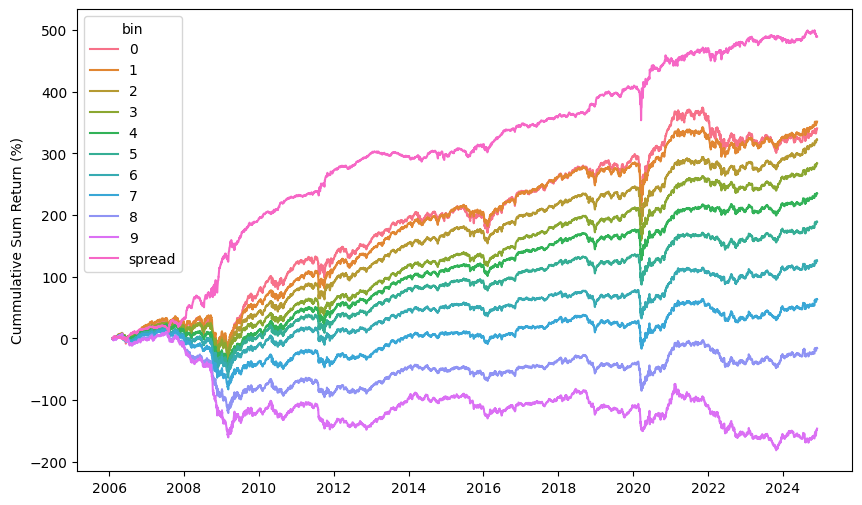

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(port, x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

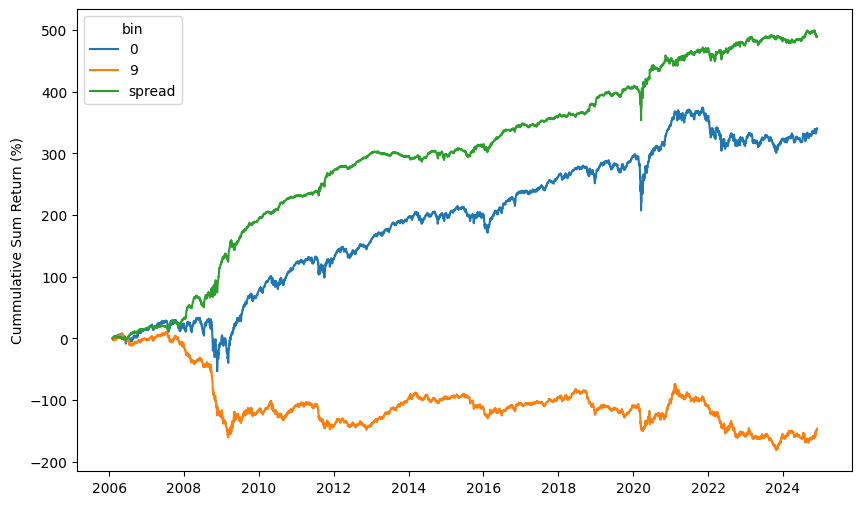

In [13]:
plt.figure(figsize=(10, 6))
sns.lineplot(port.filter(pl.col("bin").is_in(["0", "9", "spread"])), x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

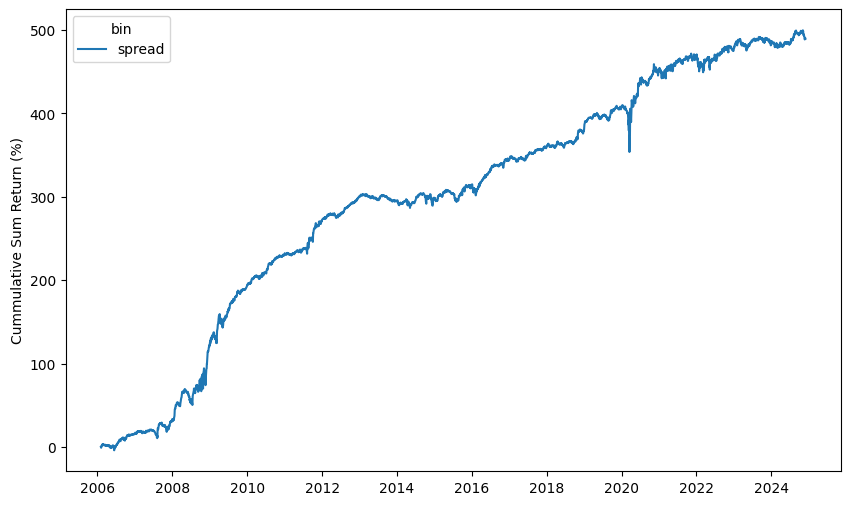

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(port.filter(pl.col("bin") == "spread"), x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

In [15]:
min_date = port["date"].min().strftime("%Y-%m-%d")
max_date = port["date"].max().strftime("%Y-%m-%d")

print(f"From {min_date} to {max_date}")

From 2006-02-03 to 2024-11-29
